In [1]:
import math
import numpy as np
import tbplas as tb

/home/alapena/miniconda3/envs/tbplas/lib/python3.12/site-packages/tbplas/cython/__init__.py:54: UserWarning: C++ hdf5 extension not found. HDF5 IO not usable.
  warnings.warn("C++ hdf5 extension not found. HDF5 IO not usable.")


In [2]:
# Create primitive cell
def make_empty_cell(algo: int = 0) -> tb.PrimitiveCell:
    """
    Generate lattice vectors of monolayer graphene.
    :param algo: algorithm to generate lattice vectors
    :return: empty primitive cell
    """
    a = 2.46  # cell length a in Angstrom
    b = a  # cell length b in Angstrom
    c = 10.0  # cell length c in Angstrom
    gamma = 60.0  # angle between a1 and a2 in Degrees
    a_half = a * 0.5
    sqrt3 = math.sqrt(3)
    if algo == 0:
        vectors = tb.gen_lattice_vectors(a=a, b=b, c=c, gamma=gamma)
    elif algo == 1:
        vectors = np.array([
            [a, 0, 0,],
            [a_half, sqrt3*a_half, 0],
            [0, 0, c]])
    else:
        vectors = np.array([
            [sqrt3*a_half, -a_half, 0],
            [sqrt3*a_half, a_half, 0],
            [0, 0, c]])
    cell = tb.PrimitiveCell(vectors, unit=tb.ANG)
    return cell 


def add_orbitals(cell: tb.PrimitiveCell, algo: int = 0) -> None:
    """
    Add orbitals to the model.
    :param algo: algorithm to add orbitals
    :return: None. The incoming cell is modified.
    """
    if algo == 0:
        cell.add_orbital((1./3, 1./3),  energy=0.0, label="pz")
        cell.add_orbital((2./3, 2./3),  energy=0.0, label="pz")
    elif algo == 1:
        cell.add_orbital((1./3, 1./3, 0.5), energy=0.0, label="pz")
        cell.add_orbital((2./3, 2./3, 0.5), energy=0.0, label="pz")
    else:
        # NOTE: Tt is assumed that a_1 should be parallel to x-axis
        cell.add_orbital_cart((1.23, 0.71014083), unit=tb.ANG, energy=0.0, label="pz")
        cell.add_orbital_cart((2.46, 1.42028166), unit=tb.ANG, energy=0.0, label="pz") 


def add_hopping_terms(cell: tb.PrimitiveCell, algo: int = 0) -> None:
    """
    Add hopping terms the model.
    :param algo: algorithm to add hopping terms
    :return: None. The incoming cell is modified.
    """
    if algo == 0:
        cell.add_hopping(rn=(0, 0), orb_i=0, orb_j=1, energy=-2.7)
        cell.add_hopping(rn=(1, 0), orb_i=1, orb_j=0, energy=-2.7)
        cell.add_hopping(rn=(0, 1), orb_i=1, orb_j=0, energy=-2.7)
    else:
        cell.add_hopping(rn=(0, 0, 0), orb_i=0, orb_j=1, energy=-2.7)
        cell.add_hopping(rn=(1, 0, 0), orb_i=1, orb_j=0, energy=-2.7)
        cell.add_hopping(rn=(0, 1, 0), orb_i=1, orb_j=0, energy=-2.7)

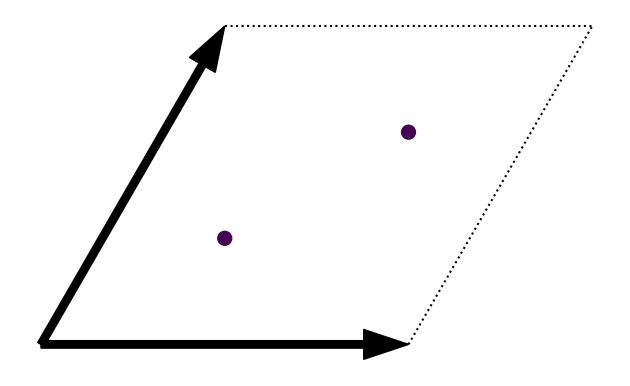

In [3]:
cell = make_empty_cell(algo=0)
add_orbitals(cell, algo=2)
# add_hopping_terms(cell, algo=0)
cell.plot()
# cell.print_hk()

# Band structure and DOS


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : graphene

Using Eigen backend for diagonalization.


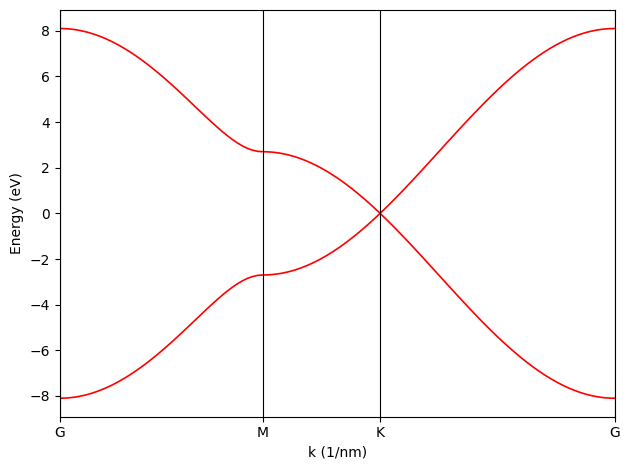

In [4]:
cell = tb.make_graphene_diamond()
k_points = np.array([
    [0.0, 0.0, 0.0],    # Gamma
    [1./2, 0.0, 0.0],   # M
    [2./3, 1./3, 0.0],  # K
    [0.0, 0.0, 0.0],    # Gamma
])
k_label = ["G", "M", "K", "G"]
k_path, k_idx = tb.gen_kpath(k_points, [40, 40, 40])

use_diag_solver = True
if use_diag_solver:
    solver = tb.DiagSolver(cell)
    solver.config.k_points = k_path
    solver.config.prefix = "graphene"
    k_len, bands = solver.calc_bands()
else:
    k_len, bands = tb.calc_bands(cell, k_path, prefix="graphene")

vis = tb.Visualizer()
fig_bands = vis.plot_bands(k_len, bands, k_idx, k_label)


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : graphene

Using Eigen backend for diagonalization.


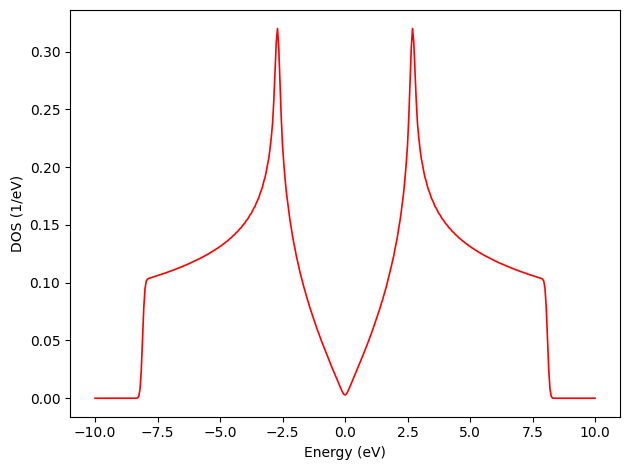

In [25]:
# DOS
k_mesh = tb.gen_kmesh((120, 120, 1))  # 120*120*1 uniform meshgrid
if True:
    solver = tb.DiagSolver(cell)
    solver.config.k_points = k_mesh
    solver.config.prefix = "graphene"
    solver.config.e_min = -10
    solver.config.e_max = 10
    solver.config.sigma = 0.07 #Default 0.05
    solver.config.num_spin = 2
    energies, dos = solver.calc_dos()
else:
    energies, dos = tb.calc_dos(cell, k_mesh, prefix="graphene", e_min=-10, e_max=10)

vis = tb.Visualizer()
fig_dos = vis.plot_dos(energies, dos)

In [26]:
solver = tb.DiagSolver(cell)
solver.config.__dict__


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   



{'prefix': 'sample',
 'k_points': array([[0., 0., 0.]]),
 'k_grid_size': (-1, -1, -1),
 'convention': 1,
 'dimension': 3,
 'num_occ': -1,
 'num_spin': 1,
 'spin_major': True,
 'e_min': -5.0,
 'e_max': 5.0,
 'e_step': 0.05,
 'sigma': 0.05,
 'smear_func': 'Gaussian',
 'ldos': False,
 'ldos_orbital_indices': {0},
 'ka_array': array([-0.5       , -0.49497487, -0.48994975, -0.48492462, -0.4798995 ,
        -0.47487437, -0.46984925, -0.46482412, -0.45979899, -0.45477387,
        -0.44974874, -0.44472362, -0.43969849, -0.43467337, -0.42964824,
        -0.42462312, -0.41959799, -0.41457286, -0.40954774, -0.40452261,
        -0.39949749, -0.39447236, -0.38944724, -0.38442211, -0.37939698,
        -0.37437186, -0.36934673, -0.36432161, -0.35929648, -0.35427136,
        -0.34924623, -0.34422111, -0.33919598, -0.33417085, -0.32914573,
        -0.3241206 , -0.31909548, -0.31407035, -0.30904523, -0.3040201 ,
        -0.29899497, -0.29396985, -0.28894472, -0.2839196 , -0.27889447,
        -0.27386935

# Non-orthogonality

In [7]:
import numpy as np
import tbplas as tb

def make_overlap(prim_cell: tb.PrimitiveCell,
                 on_site: float = 1.0,
                 hop: float = 0.0) -> tb.PrimitiveCell:
    """
    Make an overlap for given primitive cell.

    :param prim_cell: primitive cell from which the overlap will be generated
    :param on_site: on-site term of the overlap
    :param hop: hopping terms of the overlap
    :return: overlap with the same numbers of orbitals and hopping terms as the model
    """
    overlap = tb.PrimitiveCell(prim_cell.lat_vec, prim_cell.origin, 1.0)
    for i in range(prim_cell.num_orb):
        orbital = prim_cell.orbitals[i]
        overlap.add_orbital(orbital.position, on_site)

    overlap.add_hopping((0, 0), 0, 1, hop)
    overlap.add_hopping((1, 0), 1, 0, hop)
    overlap.add_hopping((0, 1), 1, 0, hop)
    return overlap


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : graphene

Using Eigen backend for diagonalization.
	 bands :    0.01087


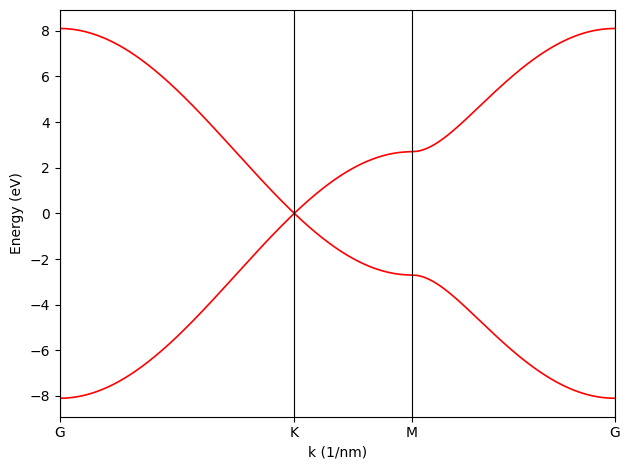

In [8]:
prim_cell = tb.make_graphene_diamond()
overlap = make_overlap(prim_cell, on_site=1.0, hop=0.0)
#overlap = make_overlap(prim_cell, on_site=0.8, hop=0.1)
solver = tb.DiagSolver(prim_cell, overlap)

k_points = np.array([
    [0.0, 0.0, 0.0],
    [2./3, 1./3, 0.0],
    [0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0]
])
k_path, k_idx = tb.gen_kpath(k_points, (1000, 1000, 1000))
solver.config.prefix = "graphene"
solver.config.k_points = k_path

timer = tb.Timer()
timer.tic("bands")
k_len, bands = solver.calc_bands()
timer.toc("bands")

if solver.is_master:
    timer.report_total_time()
    vis = tb.Visualizer()
    vis.plot_bands(k_len, bands, k_idx, ["G", "K", "M", "G"])


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : graphene

Using Eigen backend for diagonalization.
	 bands :    0.01092


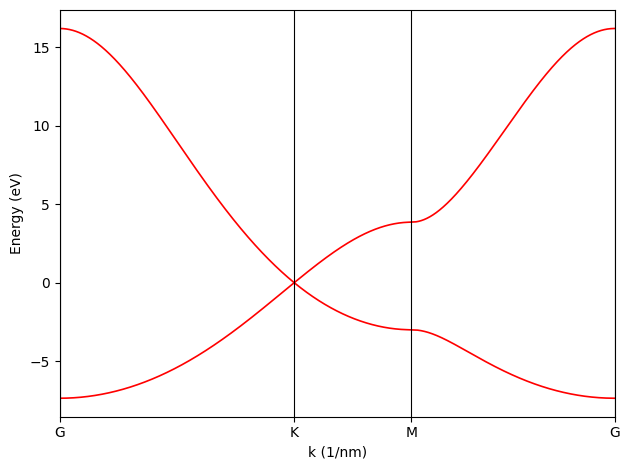

In [9]:
prim_cell = tb.make_graphene_diamond()
# overlap = make_overlap(prim_cell, on_site=1.0, hop=0.0)
overlap = make_overlap(prim_cell, on_site=0.8, hop=0.1)
solver = tb.DiagSolver(prim_cell, overlap)

k_points = np.array([
    [0.0, 0.0, 0.0],
    [2./3, 1./3, 0.0],
    [0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0]
])
k_path, k_idx = tb.gen_kpath(k_points, (1000, 1000, 1000))
solver.config.prefix = "graphene"
solver.config.k_points = k_path

timer = tb.Timer()
timer.tic("bands")
k_len, bands = solver.calc_bands()
timer.toc("bands")

if solver.is_master:
    timer.report_total_time()
    vis = tb.Visualizer()
    vis.plot_bands(k_len, bands, k_idx, ["G", "K", "M", "G"])

In [10]:
k_mesh = tb.gen_kmesh((120, 120, 1))  # 120*120*1 uniform meshgrid
k_mesh.shape

(14400, 3)

# AC Conductivity

In [ ]:
lind = tb.Lindhard(cell)
n_ks = 1500

cfg = lind.config
cfg.prefix       = "ac_cond_demo"   # basename for saved results (optional)
cfg.e_min        = 0             # energy (omega) range in eV
cfg.e_max        = 20
cfg.e_step       = 0.05             # resolution (smaller → finer grid) default: 0.05
cfg.dimension    = 3                # 2 for genuinely 2D materials. 3 to allow epsilon_q0 calculation (ojo las units!)
cfg.num_spin     = 2                # spin degeneracy
cfg.k_grid_size  = (n_ks, n_ks, 1)    # k-mesh (increase for convergence)
cfg.delta        = 0.005 # Broadening? Default 0.005

# Optional (commonly used) physics knobs:
# cfg.mu            = 0.0           # chemical potential (eV)
# cfg.temperature   = 300      # temperature (K)
# cfg.back_epsilon  = 1.0           # background dielectric constant
cfg.ac_cond_component = 1      # choose σ_xx, σ_yy, etc.

timer = tb.Timer()
timer.tic("ac_cond_demo")
omegas, ac_cond = lind.calc_ac_cond()
timer.toc("ac_cond_demo")


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : ac_cond_demo



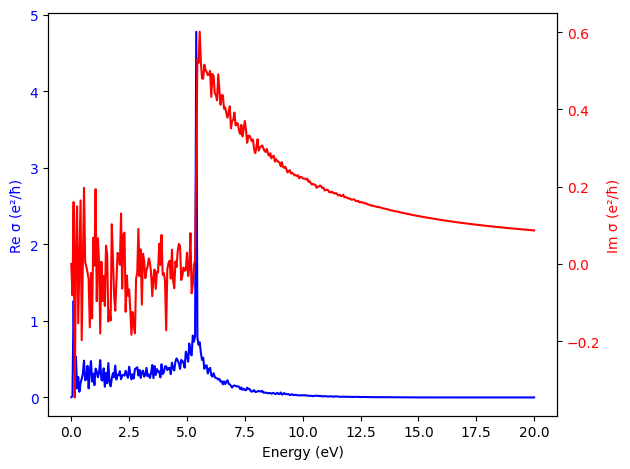

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Plot the real part on the first y-axis
ax1.plot(omegas, ac_cond.real, color='blue', label='Re σ')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel("Re σ (e²/ħ)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(omegas, ac_cond.imag, color='red', label='Im σ')
ax2.set_ylabel("Im σ (e²/ħ)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

Dielectric function

In [ ]:
timer = tb.Timer()
timer.tic("diel_demo")
eps_q0 = lind.calc_epsilon_q0(omegas, ac_cond)
timer.toc("diel_demo")

/home/alapena/miniconda3/envs/tbplas/lib/python3.12/site-packages/tbplas/diag/lindhard.py:265: RuntimeWarning: divide by zero encountered in divide
  return 1 + 1j * prefactor * ac_cond / omegas


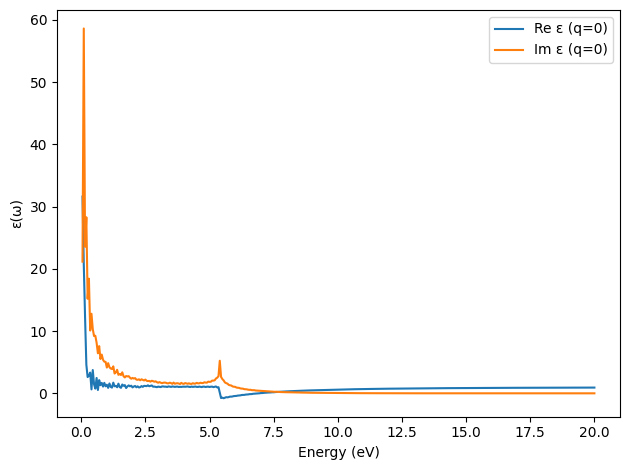

In [ ]:
plt.plot(omegas, eps_q0.real, label="Re ε (q=0)")
plt.plot(omegas, eps_q0.imag, label="Im ε (q=0)")
plt.xlabel("Energy (eV)")
plt.ylabel("ε(ω)")
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
cfg.__dict__

{'prefix': 'ac_cond_demo',
 'k_points': array([[0., 0., 0.]]),
 'k_grid_size': (900, 900, 1),
 'convention': 1,
 'dimension': 3,
 'num_occ': -1,
 'num_spin': 2,
 'spin_major': True,
 'e_min': 0,
 'e_max': 20,
 'e_step': 0.05,
 'sigma': 0.05,
 'smear_func': 'Gaussian',
 'ldos': False,
 'ldos_orbital_indices': {0},
 'ka_array': array([-0.5       , -0.49497487, -0.48994975, -0.48492462, -0.4798995 ,
        -0.47487437, -0.46984925, -0.46482412, -0.45979899, -0.45477387,
        -0.44974874, -0.44472362, -0.43969849, -0.43467337, -0.42964824,
        -0.42462312, -0.41959799, -0.41457286, -0.40954774, -0.40452261,
        -0.39949749, -0.39447236, -0.38944724, -0.38442211, -0.37939698,
        -0.37437186, -0.36934673, -0.36432161, -0.35929648, -0.35427136,
        -0.34924623, -0.34422111, -0.33919598, -0.33417085, -0.32914573,
        -0.3241206 , -0.31909548, -0.31407035, -0.30904523, -0.3040201 ,
        -0.29899497, -0.29396985, -0.28894472, -0.2839196 , -0.27889447,
        -0.27386